
The steps of pipeline are:

1. Detect vehicles from a input image.
2. Crop the ROIs with BBOX of vehicles detections.
3. Detect plates from cropped vehicle images.
4. Crop the ROIs with BBOX of plate detections.
5. Extract the plate number with OCR from croped plate detections.

# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Summary</p>


<p style="font-family:newtimeroman;font-weight:600;color:#682F2F;font-size:150%; border-bottom: 2px solid #682F2F;">1 | Librarys and Packeges</p>
<p style="font-family:newtimeroman;font-weight:600;color:#682F2F;font-size:150%; border-bottom: 2px solid #682F2F;">2 | Configurations</p>
<p style="font-family:newtimeroman;font-weight:600;color:#682F2F;font-size:150%; border-bottom: 2px solid #682F2F;">3 | Utils</p>
<p style="font-family:newtimeroman;font-weight:600;color:#682F2F;font-size:150%; border-bottom: 2px solid #682F2F;">4 | Data</p>
<p style="font-family:newtimeroman;font-weight:600;color:#682F2F;font-size:150%; border-bottom: 2px solid #682F2F;">6 | YAML file</p>
<p style="font-family:newtimeroman;font-weight:600;color:#682F2F;font-size:150%; border-bottom: 2px solid #682F2F;">7 | Images</p>
<p style="font-family:newtimeroman;font-weight:600;color:#682F2F;font-size:150%; border-bottom: 2px solid #682F2F;">8 | Train Detection Model</p>
<p style="font-family:newtimeroman;font-weight:600;color:#682F2F;font-size:150%; border-bottom: 2px solid #682F2F;">9 | Results</p>
<p style="font-family:newtimeroman;font-weight:600;color:#682F2F;font-size:150%; border-bottom: 2px solid #682F2F;">10 | OCR</p>

# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Librarys  and Packeges</p>

In [1]:
!pip install --upgrade ultralytics -qq
!pip install GPUtil -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.3/709.3 kB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
!pip install easyocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 66.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 33.6 MB/s eta 0:00:00


In [3]:
!pip install pytesseract

In [4]:
import warnings
warnings.filterwarnings("ignore")

import os
import shutil
import re
import glob
import subprocess
import random
import yaml
import tqdm
import gc


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import IPython.display as display
from IPython.display import Video
from PIL import Image
import cv2

import ultralytics
from ultralytics import YOLO

import easyocr

import xml.etree.ElementTree as xet
from bs4 import BeautifulSoup

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda
import pytesseract

print('ultralytics version: ',ultralytics.__version__)

ultralytics version:  8.1.9


# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Configurations 🔧</p>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
class CFG:

    #paths
    out_folder = f'/content/drive/MyDrive/Kaggle/working-car-model'
    class_name = ['car_plate']
    video_test_path = 'https://docs.google.com/uc?export=download&confirm=&id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-'

    weights = 'yolov8s.pt'
    exp_name = 'car_plate_detection'
    img_size = (240,400)
    vehicles_class = [2, 3, 5, 7]

    #Yolo train parameters
    epochs = 50
    batch_size = 16
    optimizer = 'Adam' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    lr = 1e-3
    lr_factor = 0.01 #lo*lr_f
    weight_decay = 5e-4
    dropout = 0.0
    patience = int(0.7*epochs)
    profile = False
    label_smoothing = 0.0

    #models Confidance
    vehicle_conf = 0.5
    plate_conf = 0.3
    ocr_conf = 0.1

    seed = 42



# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Utils 🔧</p>

In [7]:
def get_bbox(file_path):

    info = xet.parse(file_path)
    root = info.getroot()
    member_object = root.find('object')

    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    return  xmin, xmax, ymin, ymax



def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.seed):

    random.seed(seed)

    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]



    # Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        img = cv2.imread(os.path.join(folder_path, file_name))


        xmin, xmax, ymin, ymax = get_bbox(file_path=os.path.join('/content/drive/MyDrive/Kaggle/car-plate-detection/annotations',
                                                                 file_name.replace('.png','.xml')))



        start_point = (xmin, ymax)
        end_point = (xmax, ymin)

        img = cv2.rectangle(img, start_point, end_point, (255,0,0), 3)


        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]

        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(file_name)

    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()

def parse_xml_tags(data):
    """Parse xml label file, return image file name, and its coordinates as a dictionary
    """
    tags = ['filename', 'width', 'height', 'xmin', 'ymin', 'xmax', 'ymax']
    Bs_data = BeautifulSoup(data, "xml")
    d = dict()

    for t in tags:
        text = Bs_data.find(t).text
        if all(c.isdigit() for c in text):
            d[t] = int(text)
        else:
            d[t] = text
    return d




def convert_xml_txt_yolo(file_path,w_image,h_image):

    with open(file_path,  'r') as f:
        label = parse_xml_tags(f.read())


    xmin = int(label['xmin'])
    xmax = int(label['xmax'])
    ymin = int(label['ymin'])
    ymax = int(label['ymax'])


    x_center = float((xmin+((xmax-xmin)/2))/w_image)
    y_center = float((ymin+((ymax-ymin)/2))/h_image)

    width = float((xmax-xmin)/w_image)
    height = float((ymax-ymin)/h_image)

    str_out = f'0 {x_center} {y_center} {width} {height}'

    return str_out

def display_image(image, print_info = True, hide_axis = False, figsize = (15,15), title=None):
    fig = plt.figure(figsize = figsize)
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)

        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        if image.shape[-1] == 3:
            image = image[..., ::-1]  # BGR to RGB
            img = Image.fromarray(image)
            plt.imshow(img)
        else:
            img = np.copy(image)
            plt.imshow(img,cmap = 'gray')

    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')
    if title is not None:
        plt.title(title)

    plt.show()

def create_dir(path):

    if not os.path.exists(path):
        os.mkdir(path)

def gpu_report():
    if torch.cuda.is_available():
        # Get the number of available GPUs
        num_gpus = torch.cuda.device_count()
        print(f"Number of available GPUs: {num_gpus}")

        if num_gpus > 1:
            train_device, test_device = 0,1

        else:
            train_device, test_device = 0,0




        # Get information about each GPU
        for i in range(num_gpus):
            gpu_properties = torch.cuda.get_device_properties(i)
            print(f"\nGPU {i}: {gpu_properties.name}")
            print(f"  Total Memory: {gpu_properties.total_memory / (1024**3):.2f} GB")
            print(f"  CUDA Version: {gpu_properties.major}.{gpu_properties.minor}")


    else:
        print("CUDA is not available. You can only use CPU.")
        train_device, test_device = 'cpu', 'cpu'


    print('\n')
    gpu_usage()

    return train_device, test_device


def extract_roi(image, bounding_box):
    """
    Crop the input image based on the provided bounding box coordinates.

    Args:
        image (numpy.ndarray): The input image.
        bounding_box (tuple): A tuple containing (x_min, y_min, x_max, y_max)
            coordinates of the bounding box.

    Returns:
        numpy.ndarray: The cropped image.
    """
    x_min, x_max, y_min, y_max = bounding_box
    cropped_image = image[y_min:y_max, x_min:x_max]
    return cropped_image


def free_gpu_cache() -> None:
    print("Initial GPU Usage")
    gpu_usage()


    torch.cuda.empty_cache()


    print("GPU Usage after emptying the cache")
    gpu_usage()


def extract_ocr(roi_img, reader):

    ocr_result = reader.readtext(np.asarray(roi_img), allowlist = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    text_plate = ''
    if len(ocr_result) > 0:

        for item in ocr_result:
            text, conf = item[-2], item[-1]
            text = text if conf > CFG.ocr_conf else ''
            text_plate+=text
    else:
        text_plate, conf = 'unreco_plate', 0

    text_plate = text_plate.lower()

    #text_plate = isValidNumberPlate(text_plate)


    return text_plate,conf


def inference_inside_roi(df_coords, img, model, device ,display = False):

    bboxs = df_coords[['xmin','xmax','ymin','ymax']].values.astype(int)
    classes = df_coords['class'].values


    df_plate = pd.DataFrame()
    for i,bbox in enumerate(bboxs):

        vehicle_img = extract_roi(img, bbox)

        results = model.predict(vehicle_img,
                        conf = CFG.plate_conf,
                        classes =[0],
                        device = device,
                        verbose = False)

        position_frame = pd.DataFrame(results[0].cpu().numpy().boxes.data,
                                       columns = ['xmin', 'ymin', 'xmax',
                                                  'ymax', 'conf', 'class'])

        position_frame['class'] = position_frame['class'].replace({0:'car_plate'})
        position_frame['plate_number'] = 'unreco_plate'

        #Filter cases with more them one plate per vehicle
        position_frame = position_frame.loc[position_frame['conf'] == position_frame['conf'].max(),:]

        #adjust bbox of plate for complete image
        position_frame['xmin']+=bbox[0]
        position_frame['xmax']+=bbox[0]
        position_frame['ymin']+=bbox[2]
        position_frame['ymax']+=bbox[2]

        if display:
            display_image(vehicle_img, hide_axis = True, figsize =(10,10), title='Vehicle ROI Image')

        if len(position_frame) > 0:

            plate_bbox = position_frame[['xmin','xmax','ymin','ymax']].values.squeeze().astype(int)
            plate_img = extract_roi(img, plate_bbox)
            text_plate, conf_ocr = extract_ocr(plate_img, reader)
            position_frame['plate_number'] = text_plate

            if display:
                display_image(plate_img, hide_axis = True, figsize =(10,10), title=f'ROI Plate | Nº: {text_plate}')




        position_frame = position_frame[['xmin', 'ymin', 'xmax','ymax' ,'conf', 'class', 'plate_number']]


        df_plate = pd.concat([df_plate, position_frame], axis = 0)

    return img, df_plate

def drawBBox(df_coords, img, title = '' ,thickness=1):

    cords = df_coords[['xmin','xmax','ymin','ymax']].values.astype(int)
    classes = df_coords['class'].values

    for i,detection in enumerate(cords):


        start_point = (detection[0], detection[-1]) # x_min, y_max
        end_point = (detection[1], detection[2]) # x_max, y_min
        class_detected = classes[i]


        if class_detected == 'car_plate':
            number_plate = df_coords['plate_number'].values[i]
            cv2.rectangle(img, start_point, end_point, (0,0,190), thickness)
            cv2.putText(img=img, text=f'{class_detected} ',
                org= (detection[0], detection[2]-20),
                fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(0, 0, 255),thickness=2)
            cv2.putText(img=img, text=f'{number_plate}',
                org= (detection[0]-10, detection[-1]+30),
                fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(0, 0, 255),thickness=2)
        else:
            cv2.rectangle(img, start_point, end_point, (255,0,0), thickness)

            cv2.putText(img=img, text=f'{class_detected}',
                org= (detection[0], detection[2]-20),
                fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(255, 255, 0),thickness=2)



    return img


# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Data 📊</p>

Labels are in XML format, convert into yolo format


In [8]:
annotations_path_xml = glob.glob('/content/drive/MyDrive/Kaggle/car-plate-detection/annotations/*.xml')
image_paths = glob.glob('/content/drive/MyDrive/Kaggle/car-plate-detection/images/*.png')

info = xet.parse(annotations_path_xml[0])
xet.dump(info)

<annotation>
    <folder>images</folder>
    <filename>Cars1.png</filename>
    <size>
        <width>400</width>
        <height>248</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>licence</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>134</xmin>
            <ymin>128</ymin>
            <xmax>262</xmax>
            <ymax>160</ymax>
        </bndbox>
    </object>
</annotation>


## Train Text split

In [9]:
index = np.arange(len(annotations_path_xml))
np.random.shuffle(index)

val_index = index[:50]
test_index = index[50:100]
train_index = index[50:]
val_index = np.random.choice(index, size=50, replace=False)

print('Train Size: ', len(train_index))
print('Valid Size: ', len(val_index))
# print('Test Size: ', len(test_index))

Train Size:  383
Valid Size:  50


In [10]:
#create paths for yolo labels
create_dir(CFG.out_folder)
datasets = ['train','valid']
folders = ['images','labels']
for dataset in datasets:
    path_1 = CFG.out_folder + f'/{dataset}'
    create_dir(path_1)
    for folder in folders:
        path_2 = CFG.out_folder + f'/{dataset}/{folder}'

        create_dir(path_2)

        print(path_2)

/content/drive/MyDrive/Kaggle/working-car-model/train/images
/content/drive/MyDrive/Kaggle/working-car-model/train/labels
/content/drive/MyDrive/Kaggle/working-car-model/valid/images
/content/drive/MyDrive/Kaggle/working-car-model/valid/labels


## Convert to Yolo format

In [11]:
for i, img_path in enumerate(image_paths):
    image = cv2.imread(img_path)

    resize_image = cv2.resize(image,CFG.img_size)
    h_image,w_image,_ = image.shape

    label_path = img_path.replace('images','annotations').replace('.png','.xml')

    label_text = convert_xml_txt_yolo(label_path,w_image,h_image)


    text_file_name = img_path.split('/')[-1].replace('.png','.txt')
    img_file_name = img_path.split('/')[-1]
    # print(img_file_name)

    if i in val_index:
        dataset = 'valid'
    elif i in train_index:
        dataset = 'train'
    elif i in test_index:
        dataset = 'test'


    text_path = f'{CFG.out_folder}/' + dataset +'/labels/' + text_file_name
    new_img_path = f'{CFG.out_folder}/' + dataset +'/images/'+ img_file_name

    shutil.copy2(img_path,new_img_path)
    #cv2.imwrite(new_img_path, resize_image)


    text_file = open(text_path, "w")
    text_file.write(label_text)
    text_file.close()

# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">YAML file 📊</p>

In [13]:
dict_file = {
    'train': os.path.join(CFG.out_folder, 'train'),
    'val': os.path.join(CFG.out_folder, 'valid'),
    'nc': len(CFG.class_name),
    'names': CFG.class_name
    }

yaml_path = os.path.join(CFG.out_folder, 'data.yaml')

with open(yaml_path, 'w+') as file:
    yaml.dump(dict_file, file)

with open(yaml_path, 'r') as file:
    data_yaml = yaml.safe_load(file)

print(yaml.dump(data_yaml))

names:
- car_plate
nc: 1
train: /content/drive/MyDrive/Kaggle/working-car-model/train
val: /content/drive/MyDrive/Kaggle/working-car-model/valid



# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Images 🔬</p>

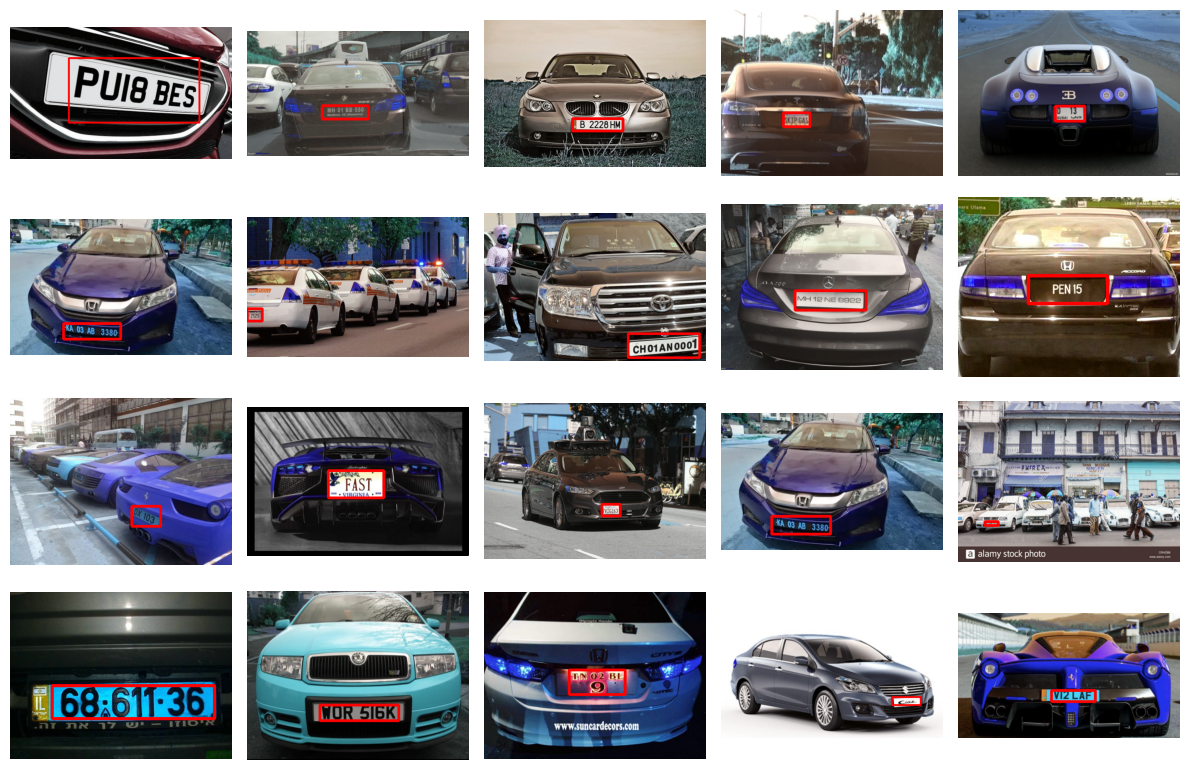

In [14]:
plot_random_images_from_folder(folder_path= '/content/drive/MyDrive/Kaggle/car-plate-detection/images',
                               num_images=20,
                               seed=CFG.seed)

# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Train Detection Model</p>

In [15]:
! wandb disabled

/bin/bash: line 1: wandb: command not found


In [16]:
plate_model = YOLO(CFG.weights)

100%|██████████| 21.5M/21.5M [00:00<00:00, 366MB/s]


## GPU Report

In [17]:
train_device, test_device = gpu_report()
plate_model.to(train_device)

print('\nModel Info')
print('Model: ', CFG.weights)
print('Device: ' ,plate_model.device)

Number of available GPUs: 1

GPU 0: NVIDIA A100-SXM4-40GB
  Total Memory: 39.56 GB
  CUDA Version: 8.0


| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |

Model Info
Model:  yolov8s.pt
Device:  cuda:0


## Train

In [18]:
%%time

### train
plate_model.train(
    data = yaml_path,

    task = 'detect',

    #imgsz = (img_properties['height'], img_properties['width']),

    epochs = CFG.epochs,
    batch = CFG.batch_size,
    optimizer = CFG.optimizer,
    lr0 = CFG.lr,
    lrf = CFG.lr_factor,
    weight_decay = CFG.weight_decay,
    dropout = CFG.dropout,
    patience = CFG.patience,
    label_smoothing = CFG.label_smoothing,
    imgsz = 640,#CFG.img_size,

    name = CFG.exp_name,
    seed = CFG.seed,
    profile = False,

    val = True,
    amp = False,   #mixed precision
    exist_ok = False, #overwrite experiment
    resume = False,
    device = train_device,
    verbose = False,
    single_cls = False,
)

Ultralytics YOLOv8.1.9 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/Kaggle/working-car-model/data.yaml, epochs=50, time=None, patience=35, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=car_plate_detection, exist_ok=False, pretrained=True, optimizer=Adam, verbose=False, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, 

100%|██████████| 755k/755k [00:00<00:00, 106MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

train: Scanning /content/drive/MyDrive/Kaggle/working-car-model/train/labels... 424 images, 0 backgrounds, 0 corrupt: 100%|██████████| 424/424 [00:07<00:00, 58.22it/s]


train: New cache created: /content/drive/MyDrive/Kaggle/working-car-model/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/Kaggle/working-car-model/valid/labels... 104 images, 0 backgrounds, 0 corrupt: 100%|██████████| 104/104 [00:07<00:00, 13.84it/s]

val: New cache created: /content/drive/MyDrive/Kaggle/working-car-model/valid/labels.cache


Plotting labels to runs/detect/car_plate_detection/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/car_plate_detection
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.34G       1.55      2.508      1.333         12        640: 100%|██████████| 27/27 [00:06<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]

                   all        104        104      0.715      0.663      0.702      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      7.41G      1.469       1.12      1.204         15        640: 100%|██████████| 27/27 [00:02<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.30it/s]

                   all        104        104      0.757      0.654      0.736       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      7.39G      1.436      1.145      1.245         18        640: 100%|██████████| 27/27 [00:02<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.29it/s]

                   all        104        104      0.199      0.587      0.178      0.094



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.39G      1.446      1.061      1.278         17        640: 100%|██████████| 27/27 [00:02<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.98it/s]

                   all        104        104      0.803      0.827      0.788      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      7.39G       1.48      1.005      1.285         17        640: 100%|██████████| 27/27 [00:02<00:00,  9.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.63it/s]

                   all        104        104        0.8      0.808      0.815      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.42G      1.474     0.9993      1.284         15        640: 100%|██████████| 27/27 [00:02<00:00,  9.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.35it/s]

                   all        104        104      0.814      0.759      0.818      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      7.43G      1.434       1.03      1.295         13        640: 100%|██████████| 27/27 [00:02<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.33it/s]

                   all        104        104      0.778      0.844      0.783      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      7.42G      1.411      0.939      1.255         19        640: 100%|██████████| 27/27 [00:02<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.89it/s]

                   all        104        104       0.66      0.779      0.693      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      7.39G      1.364     0.8606       1.23         18        640: 100%|██████████| 27/27 [00:02<00:00,  9.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.99it/s]

                   all        104        104      0.712      0.837      0.855      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.42G      1.367      0.875      1.278         15        640: 100%|██████████| 27/27 [00:02<00:00,  9.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.77it/s]

                   all        104        104      0.884      0.878      0.927      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      7.42G      1.296      0.845      1.205         15        640: 100%|██████████| 27/27 [00:02<00:00,  9.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.93it/s]

                   all        104        104      0.849      0.867       0.93      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      7.41G      1.311     0.8379      1.217         14        640: 100%|██████████| 27/27 [00:02<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.79it/s]

                   all        104        104      0.837      0.888      0.939       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      7.39G      1.336     0.8636      1.237         21        640: 100%|██████████| 27/27 [00:02<00:00,  9.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.26it/s]

                   all        104        104      0.921      0.902      0.962      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      7.42G      1.296     0.8154      1.209         16        640: 100%|██████████| 27/27 [00:02<00:00,  9.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.98it/s]

                   all        104        104      0.915      0.923       0.94      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      7.42G      1.306     0.7703       1.21         14        640: 100%|██████████| 27/27 [00:02<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.97it/s]

                   all        104        104      0.882      0.894      0.935      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      7.41G      1.277     0.8146      1.219         21        640: 100%|██████████| 27/27 [00:02<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.44it/s]

                   all        104        104       0.84      0.957      0.947      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      7.39G      1.254     0.7591      1.193         17        640: 100%|██████████| 27/27 [00:03<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.29it/s]

                   all        104        104      0.908      0.946      0.958      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      7.42G      1.274     0.7626       1.19         14        640: 100%|██████████| 27/27 [00:02<00:00,  9.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.91it/s]

                   all        104        104      0.866      0.923      0.957      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.42G      1.265     0.7633      1.173         14        640: 100%|██████████| 27/27 [00:02<00:00,  9.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.49it/s]

                   all        104        104      0.874      0.936      0.966      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      7.43G      1.273     0.7449      1.175         15        640: 100%|██████████| 27/27 [00:02<00:00,  9.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.48it/s]

                   all        104        104      0.864      0.916      0.946      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.39G      1.229     0.7671      1.196         12        640: 100%|██████████| 27/27 [00:02<00:00,  9.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.96it/s]

                   all        104        104      0.868      0.894      0.952      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.42G      1.253     0.7767      1.178         24        640: 100%|██████████| 27/27 [00:02<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.93it/s]

                   all        104        104      0.895      0.875      0.933        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      7.41G       1.21     0.7343      1.152         19        640: 100%|██████████| 27/27 [00:02<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.05it/s]

                   all        104        104      0.924      0.913      0.962      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      7.41G      1.128     0.6929      1.128         19        640: 100%|██████████| 27/27 [00:02<00:00,  9.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.78it/s]

                   all        104        104      0.891      0.913      0.946       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.39G      1.198     0.6884      1.159         12        640: 100%|██████████| 27/27 [00:02<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.25it/s]

                   all        104        104      0.892      0.954      0.941       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.42G      1.113     0.6539      1.107         15        640: 100%|██████████| 27/27 [00:02<00:00,  9.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.75it/s]

                   all        104        104      0.914      0.952      0.957      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      7.42G      1.115     0.6544      1.121         12        640: 100%|██████████| 27/27 [00:02<00:00,  9.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.49it/s]

                   all        104        104      0.872      0.962      0.965      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.43G      1.121     0.6343       1.11         13        640: 100%|██████████| 27/27 [00:02<00:00,  9.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.88it/s]


                   all        104        104      0.918      0.952      0.972      0.674

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      7.41G      1.125     0.6728      1.133         16        640: 100%|██████████| 27/27 [00:02<00:00,  9.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.33it/s]

                   all        104        104      0.936      0.962      0.974      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      7.42G      1.135      0.633      1.122         12        640: 100%|██████████| 27/27 [00:02<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.59it/s]

                   all        104        104      0.886      0.962      0.963      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      7.41G      1.089     0.6357      1.097         14        640: 100%|██████████| 27/27 [00:02<00:00,  9.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.47it/s]

                   all        104        104      0.916      0.952      0.965      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.42G      1.119      0.623      1.117         14        640: 100%|██████████| 27/27 [00:02<00:00,  9.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.39it/s]

                   all        104        104      0.926      0.958      0.978      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      7.39G      1.089     0.5988      1.093         13        640: 100%|██████████| 27/27 [00:02<00:00,  9.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.70it/s]

                   all        104        104      0.918      0.971      0.956      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      7.42G      1.072     0.6014      1.073         11        640: 100%|██████████| 27/27 [00:02<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.27it/s]

                   all        104        104      0.943      0.958      0.979       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.42G      1.062      0.612      1.104         18        640: 100%|██████████| 27/27 [00:02<00:00,  9.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.58it/s]

                   all        104        104      0.919       0.98      0.975      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      7.42G       1.06     0.5887      1.097         14        640: 100%|██████████| 27/27 [00:02<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.84it/s]

                   all        104        104      0.918      0.963      0.967      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.39G      1.056     0.5731      1.094         16        640: 100%|██████████| 27/27 [00:02<00:00,  9.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.74it/s]

                   all        104        104      0.926      0.969      0.968      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      7.43G      1.003     0.5753      1.068         15        640: 100%|██████████| 27/27 [00:02<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.10it/s]

                   all        104        104      0.917       0.99      0.971      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      7.43G       0.99     0.5463      1.068         21        640: 100%|██████████| 27/27 [00:02<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.38it/s]

                   all        104        104       0.93       0.99      0.975      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      7.42G      1.013     0.5611      1.082         14        640: 100%|██████████| 27/27 [00:02<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.81it/s]

                   all        104        104      0.945      0.971       0.98      0.722


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      7.41G     0.9665     0.5246      1.076          8        640: 100%|██████████| 27/27 [00:05<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.68it/s]

                   all        104        104      0.963      0.942      0.982      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      7.42G     0.9653     0.5223      1.061          8        640: 100%|██████████| 27/27 [00:02<00:00,  9.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.14it/s]

                   all        104        104      0.935      0.966      0.979      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      7.42G     0.9526     0.4937      1.052          8        640: 100%|██████████| 27/27 [00:02<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.72it/s]

                   all        104        104      0.946      0.952      0.969      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      7.42G     0.9357     0.4993      1.049          8        640: 100%|██████████| 27/27 [00:02<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.58it/s]

                   all        104        104      0.969      0.971      0.978      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      7.39G     0.9583     0.4907      1.057          8        640: 100%|██████████| 27/27 [00:02<00:00,  9.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.22it/s]


                   all        104        104      0.966      0.971      0.982      0.731

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      7.42G     0.9515     0.4988      1.053          8        640: 100%|██████████| 27/27 [00:02<00:00,  9.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.33it/s]

                   all        104        104      0.936      0.988       0.98      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      7.42G     0.9336     0.4822      1.042          8        640: 100%|██████████| 27/27 [00:02<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.80it/s]

                   all        104        104      0.943      0.981      0.972      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      7.42G     0.9352     0.4774      1.044          8        640: 100%|██████████| 27/27 [00:02<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.41it/s]

                   all        104        104      0.941      0.971      0.972      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      7.39G     0.9245     0.4807       1.03          8        640: 100%|██████████| 27/27 [00:02<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.92it/s]

                   all        104        104      0.943       0.99      0.977      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      7.42G     0.8749     0.4618      1.027          8        640: 100%|██████████| 27/27 [00:02<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.71it/s]

                   all        104        104      0.945      0.986      0.981      0.751



50 epochs completed in 0.063 hours.
Optimizer stripped from runs/detect/car_plate_detection/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/car_plate_detection/weights/best.pt, 22.5MB

Validating runs/detect/car_plate_detection/weights/best.pt...
Ultralytics YOLOv8.1.9 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.13it/s]


                   all        104        104      0.945      0.986      0.981       0.75
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 8.4ms postprocess per image
Results saved to runs/detect/car_plate_detection
CPU times: user 3min 48s, sys: 36.3 s, total: 4min 24s
Wall time: 4min 21s


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7816ffed4dc0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

## Save Model

In [19]:
plate_model.export(
    format = 'openvino', # openvino, onnx, engine, tflite
    imgsz = 640, #CFG.img_size,
    half = False, #fp16
    int8 = False,
    simplify = False,
    nms = False,
)

Ultralytics YOLOv8.1.9 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs

PyTorch: starting from 'runs/detect/car_plate_detection/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (21.5 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 307.5 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 7.6s, installed 1 package: ['onnx>=1.12.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.15.0 opset 17...
ONNX: export success ✅ 8.6s, saved as 'runs/detect/car_plate_detection/weights/best.onnx' (42.6 MB)
requirements: Ultralytics requirement ['openvino-dev>=2023.0'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 83.4 MB/s eta 0:00:00
  P

'runs/detect/car_plate_detection/weights/best_openvino_model'

# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Train Results</p>

In [37]:
!apt-get install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tree is already the newest version (2.0.2-1).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


In [38]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [43]:
res_path = '/content/drive/MyDrive/Kaggle/working-car-model/car_plate_detection/' + os.listdir('/content/drive/MyDrive/Kaggle/working-car-model/car_plate_detection/')[-1]
!tree {res_path}

/content/drive/MyDrive/Kaggle/working-car-model/car_plate_detection/train_batch1.jpg  [error opening dir]

0 directories, 0 files


## Validation Examples

In [23]:
plots_path = [f for f in os.listdir(res_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

batchs_plot = [f for f in plots_path if 'val_batch' in f]
curves_plot = [f for f in plots_path if 'curve' in f]

print('Examples BBOX ')
for path in batchs_plot:
    print(''.join(path.split('/')))
    display_image(os.path.join(res_path,path), hide_axis = True)


FileNotFoundError: [Errno 2] No such file or directory: '/content/runs/detect/car_plate_detection2'

## Classification Curves

In [24]:
print('Curves Metrics')
for path in curves_plot:
    print(''.join(path.split('/')))
    display_image(os.path.join(res_path,path), hide_axis = True)

Curves Metrics


NameError: name 'curves_plot' is not defined

## Loss and MAPE

In [25]:
display_image(os.path.join(res_path,'results.png'))

FileNotFoundError: [Errno 2] No such file or directory: '/content/runs/detect/car_plate_detection2/results.png'

<Figure size 1500x1500 with 0 Axes>

# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Inference Pipeline</p>

In [ ]:
# plate_model = YOLO('/kaggle/input/best-model-car-plate-detection/best.pt')
vehicle_model = YOLO(CFG.weights)
reader = easyocr.Reader(['en'],  gpu=True if test_device != 'cpu' else False)

plate_model.to(test_device)
vehicle_model.to(test_device)

print('\nModels Info')
print('Plate Model: ', plate_model.device, 'Vehicle Model: ', plate_model.device)

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Models Info
Plate Model:  cuda:0 Vehicle Model:  cuda:0


In [ ]:
dict_all_classes = vehicle_model.model.names
dict_classes = {}
for id_class in CFG.vehicles_class:
    dict_classes[id_class] = dict_all_classes[id_class]

dict_classes

{2: 'car', 3: 'motorcycle', 5: 'bus', 7: 'truck'}

In [ ]:
test_images = glob.glob('/content/drive/MyDrive/Kaggle/car-plate-detection/images/*.png')

In [ ]:
def run_pipeline(path, display=False):

    '''
    1. Detect vehicles from a input image.
    2. Crop the ROIs with BBOX of vehicles detections.
    3. Detect plates from croped vehicle images.
    4. Crop the ROIs with BBOX of plate detections.
    5. Extract the plate number with OCR from croped plate detections.
    '''

    image = cv2.imread(path)

    if display:
        display_image(image,
                      hide_axis =True,
                      figsize = (10,10),
                      title='Input Image')

    #1
    vehicle_results = vehicle_model.predict(image,
                            conf =CFG.vehicle_conf,
                            classes = CFG.vehicles_class,
                            device = test_device,
                            verbose = False,

                                 )

    df_vehicles = pd.DataFrame(vehicle_results[0].cpu().numpy().boxes.data,
                                   columns = ['xmin', 'ymin', 'xmax',
                                              'ymax','conf', 'class'])
    df_vehicles['class'] = df_vehicles['class'].replace(dict_classes)


    # 2, 3,4
    image, df_plates = inference_inside_roi(df_vehicles,
                                                image,
                                                plate_model,
                                                test_device,
                                                display = display)

    df_frame = pd.concat([df_vehicles, df_plates], axis = 0).reset_index(drop=True)

    #Draw results in output images
    image = drawBBox(df_frame, image, thickness=5)

    if display:
        display_image(image,
                      hide_axis =True,
                      figsize = (10,10),
                      title='Output Image')

    return df_frame, image

## visualizing the flow of pipeline

In [ ]:
print(test_images)

[]


Type:  <class 'PIL.Image.Image'> 

Shape:  (267, 400, 3) 



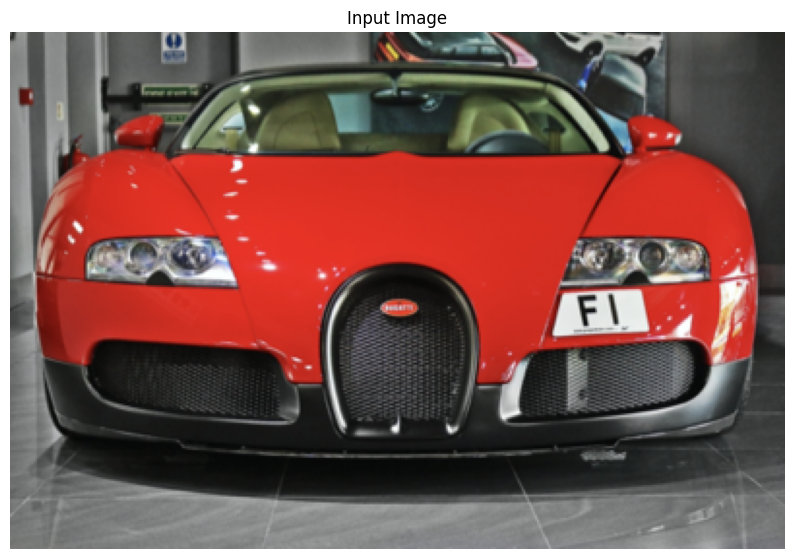

Type:  <class 'PIL.Image.Image'> 

Shape:  (221, 386, 3) 



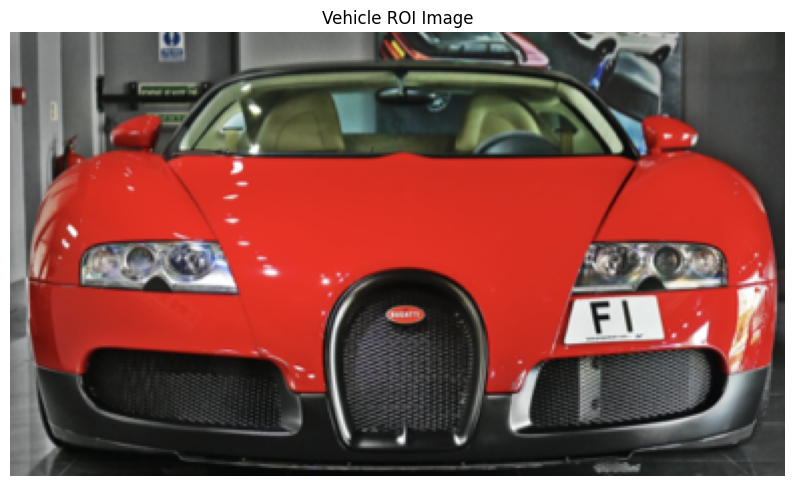

Type:  <class 'PIL.Image.Image'> 

Shape:  (27, 45, 3) 



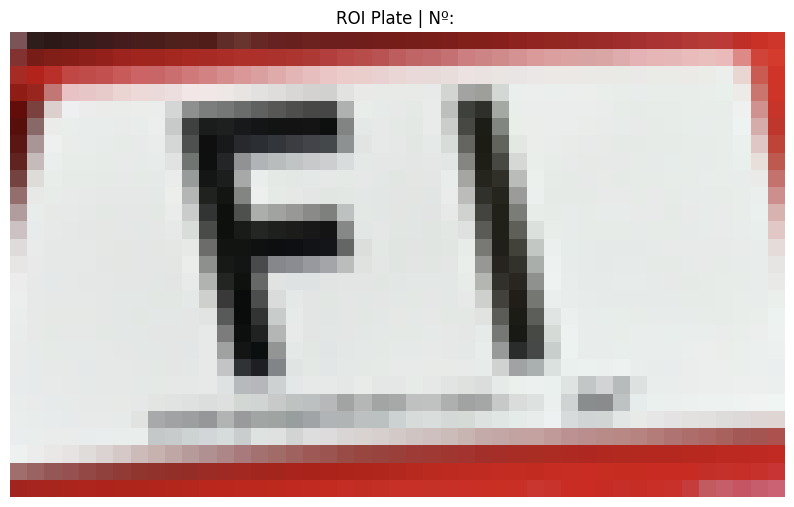

Type:  <class 'PIL.Image.Image'> 

Shape:  (267, 400, 3) 



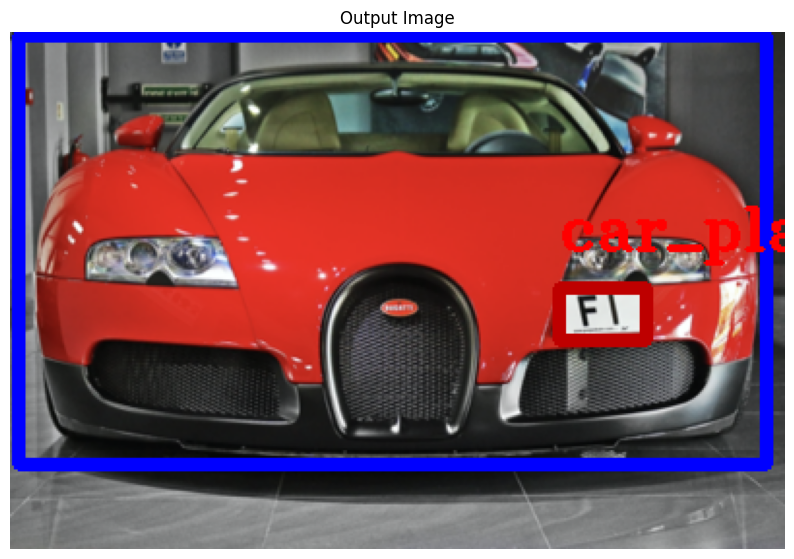

In [ ]:
df_frame, out_image  = run_pipeline(path = test_images[0], display=True)



## More Inferences

In [ ]:
n_inferences = 15

num_cols = 3
num_rows = (n_inferences + num_cols - 1) // num_cols
fig,axes = plt.subplots(num_rows,num_cols, figsize=(num_cols*6, num_rows*7))



for i in range(n_inferences):
    df_frame, out_image  = run_pipeline(path = test_images[i], display=False)

    if num_rows == 1:
        ax = axes[i % num_cols]
    else:
        ax = axes[i // num_cols, i % num_cols]

    out_image = cv2.cvtColor(out_image, cv2.COLOR_BGR2RGB)
    ax.imshow(out_image)

    ax.axis('off')
    ax.set_title(f'Output Image - {i}')

Output hidden; open in https://colab.research.google.com to view.